In [1]:
import torch
import os
import numpy as np
import random
import cv2
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def set_seed(seed=42):
    # Python's random module
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

In [3]:
dataset_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\train'

In [4]:
class RandomAffineWithInpainting:
    def __init__(self, degrees=0, translate=(0.2, 0.2), radius=3):
        self.affine = transforms.RandomAffine(degrees=degrees, translate=translate)
        self.inpaint_radius = radius

    def __call__(self, img):
        # Step 1: Apply affine transform (returns PIL image)
        img = self.affine(img)

        # Step 2: Convert to NumPy array
        img_np = np.array(img)

        # Step 3: Create mask where pixels are black
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        mask = cv2.inRange(gray, 0, 1)

        # Step 4: Inpaint using OpenCV
        inpainted_np = cv2.inpaint(img_np, mask, self.inpaint_radius, cv2.INPAINT_TELEA)

        # Step 5: Convert back to PIL
        img_inpainted = Image.fromarray(inpainted_np)

        return img_inpainted

# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    RandomAffineWithInpainting(degrees=0, translate=(0.2, 0.2))
])

# Define the augmentation path
augmentation_path = [
    r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\train\thread_water',
    r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\train\drowning',
]

# Dictionaries to hold augmented images for each category
categories = ['thread_water', 'drowning']
augmented_images = {cat: [] for cat in categories}
max_images_per_class = 5878

# Apply augmentation to images in the selected folders until reaching the max count
for i, folder_path in enumerate(augmentation_path):
    category = categories[i]
    label = i+1
    
    current_image_count = len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    required_images = max_images_per_class - current_image_count

    # Augment until enough images are created
    while len(augmented_images[category]) < required_images:
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path)
                aug_img = augmentation_transforms(img)

                # Append as tuple (image, label)
                augmented_images[category].append((aug_img, label))

                if len(augmented_images[category]) >= required_images:
                    break


In [5]:
# Create a custom dataset to combine augmented images and original images
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, augmented_images, transform=None):
        self.original_images = original_dataset.imgs  # (path, label)
        self.transform = transform

        # Convert dict of lists into one list of (image, label) tuples
        self.augmented_data = []
        for img_list in augmented_images.values():
            self.augmented_data.extend(img_list)  # List of (PIL Image, label)

    def __len__(self):
        return len(self.original_images) + len(self.augmented_data)

    def __getitem__(self, idx):
        if idx < len(self.original_images):
            img_path, label = self.original_images[idx]
            img = Image.open(img_path)
        else:
            img, label = self.augmented_data[idx - len(self.original_images)]

        if self.transform:
            img = self.transform(img)

        return img, label
    
class CustomTransformation(object):
    def __call__(self, img):
        # Ensure the image is in PIL format before converting
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)  # Convert tensor to PIL image
        
        # Convert the image to HSV using PIL
        img_hsv = np.array(img.convert("RGB"))  # Convert to numpy array (RGB)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)  # Convert to HSV
        
        # Split the HSV image into H, S, and V channels
        h, s, v = cv2.split(img_hsv)
        
        # Apply average blurring to the V channel
        v_blurred = cv2.blur(v, (7, 7))  # Apply 3x3 average blur to the V channel
        
        # Merge the H, S, and blurred V channels back together
        img_hsv_blurred = cv2.merge([h, s, v_blurred])
        
        # Convert the image back to PIL format
        return Image.fromarray(img_hsv_blurred)

In [6]:
# Define the transformation
transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    CustomTransformation(),
    transforms.ToTensor()
])

# Load the original dataset
original_dataset = ImageFolder(dataset_path, transform=None)

# Combine the dataset
full_dataset = CombinedDataset(original_dataset, augmented_images, transformations)

# Create DataLoader to load data in batches (Split 80:20)
batch_size = 32
train_size = int(0.80 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check the sizes of the splits
print(f"Total subset images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Total subset images: 17634
Training images: 14107
Validation images: 3527


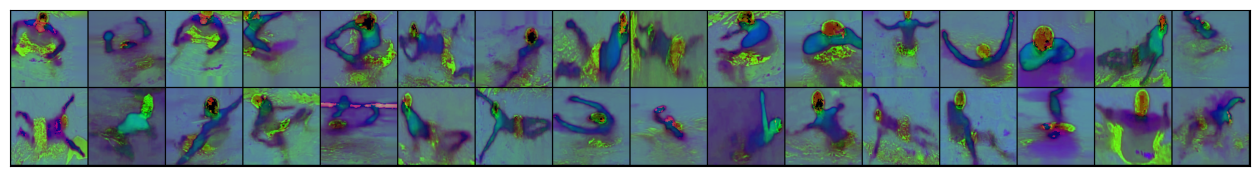

In [7]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [8]:
# Accuracy Calculation Function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Evaluation Function (Validation Phase)
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# Training Loop Function
def fit(num_epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        
        for batch in train_loader:
            loss_dict = model.training_step(batch)
            loss = loss_dict['train_loss']
            acc = loss_dict['train_acc']
            
            train_losses.append(loss)
            train_accs.append(acc)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        
        # Record train and validation stats
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


# Base Class for Image Classification Models
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                        # Generate predictions
        loss = F.cross_entropy(out, labels)       # Calculate loss
        acc = accuracy(out, labels)               # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc} 
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                        # Generate predictions
        loss = F.cross_entropy(out, labels)       # Calculate loss
        acc = accuracy(out, labels)               # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


# The Model (for 128x128 images)
class SimpleCNN(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 16x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 8x8
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        x = self.network(xb)
        x = self.fc_layers(x)
        return x


In [9]:
num_epochs = 10
model = SimpleCNN(3)
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.6749, train_acc: 0.6892, val_loss: 0.5393, val_acc: 0.7663
Epoch [1], train_loss: 0.4656, train_acc: 0.7972, val_loss: 0.4871, val_acc: 0.7854
Epoch [2], train_loss: 0.3695, train_acc: 0.8464, val_loss: 0.3396, val_acc: 0.8620
Epoch [3], train_loss: 0.2977, train_acc: 0.8804, val_loss: 0.3352, val_acc: 0.8645
Epoch [4], train_loss: 0.2443, train_acc: 0.9038, val_loss: 0.3082, val_acc: 0.8813
Epoch [5], train_loss: 0.1938, train_acc: 0.9232, val_loss: 0.3280, val_acc: 0.8726
Epoch [6], train_loss: 0.1538, train_acc: 0.9400, val_loss: 0.3072, val_acc: 0.8954
Epoch [7], train_loss: 0.1210, train_acc: 0.9551, val_loss: 0.3685, val_acc: 0.8898
Epoch [8], train_loss: 0.0985, train_acc: 0.9633, val_loss: 0.3807, val_acc: 0.8952
Epoch [9], train_loss: 0.0834, train_acc: 0.9686, val_loss: 0.4050, val_acc: 0.8933


In [10]:
# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


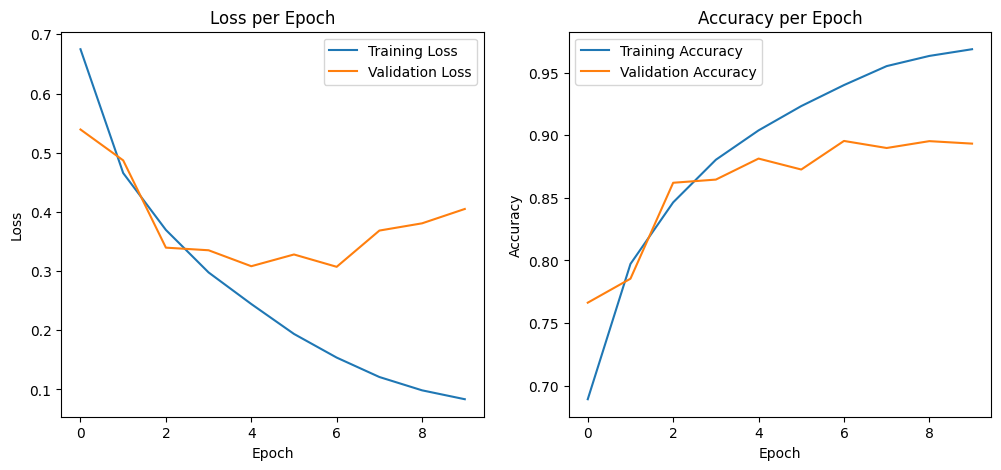

In [11]:
plot_metrics(history)

In [12]:
test_dataset_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\val'

# Load the new dataset
test_dataset = ImageFolder(test_dataset_path, transform=transformations)

# Create DataLoader for the new dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
import time

# Start timer
start_time = time.time()

test_result = evaluate(model, test_loader)

# End timer
end_time = time.time()

# Calculate time taken
time_taken = end_time - start_time

# Display results
print(f"Test Loss: {test_result['val_loss']:.4f}")
print(f"Test Accuracy: {test_result['val_acc']:.4f}")
print(f"Time Taken for Testing: {time_taken:.2f} seconds")


Test Loss: 0.2028
Test Accuracy: 0.9429
Time Taken for Testing: 15.97 seconds


In [14]:
from PIL import Image
classes = original_dataset.classes 

def predict_image(image_path, model):
    image = Image.open(image_path)
    
    # Define the transformations
    transformations = transforms.Compose([
        transforms.Resize((128, 128)),
        CustomTransformation(),
        transforms.ToTensor()
    ])
    
    img_tensor = transformations(image).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, dim=1)
    
    # Return the class label using the classes list
    return classes[predicted.item()]

In [15]:
try_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\val\drowning\200000.jpg'

print(predict_image(try_path, model))

drowning
